# Interpolate

interpolate new data into well header

In [1]:
# ONLY RUN ONCE, must restart notebook otherwise
import pandas as pd
import os
from pathlib import Path
current_dir = Path.cwd()
path = current_dir.parent
print(path)
#change directory to get src class data
os.chdir(path)
from src.data_object import *
from src.transforms import *

from src.calculable_object import *
from src.wellbore_trajectory import *

C:\Users\BpAmos\Documents\repos\directional-survey-converter


## Get Files

In [2]:
file_paths = get_files(path, folders='data')
file_paths.items

[WindowsPath('C:/Users/BpAmos/Documents/repos/directional-survey-converter/data/wellbore_survey.csv'),
 WindowsPath('C:/Users/BpAmos/Documents/repos/directional-survey-converter/data/wellbore_survey.json'),
 WindowsPath('C:/Users/BpAmos/Documents/repos/directional-survey-converter/data/wellbore_survey_many.csv'),
 WindowsPath('C:/Users/BpAmos/Documents/repos/directional-survey-converter/data/well_interpolate_data.csv')]

In [3]:
filePath = file_paths[1]
filePath

WindowsPath('C:/Users/BpAmos/Documents/repos/directional-survey-converter/data/wellbore_survey.json')

In [4]:
with open(filePath) as json_file:
    data = json.load(json_file)
json_file.close()
#data

In [5]:
from scipy import interpolate

In [6]:
filePath = file_paths[3]
df_interp = pd.read_csv(filePath, sep=',')
df_interp.head()

,wellId,var_type,name,top_depth,bottom_depth
0,well_C,wellTop,top_A,1234,1450
1,well_C,wellTop,top_B,1450,1625


In [7]:
md = np.array(data['md'])
inc = np.array(data['inc'])
azim = np.array(data['azim'])

new_md = np.array(df_interp['top_depth'])
new_md.max()

1450

In [8]:
new_md.max() - new_md.min()

216

In [49]:
f_inc = interpolate.interp1d(md, inc)
new_inc = f_inc(new_md)
new_inc


x = np.array(data['md'])
y = np.array(data['inc'])
print(x)
print(y)
f = interpolate.interp1d(x, y)

xnew = np.arange(new_md.min(), new_md.max(),216)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
print(xnew)
print(ynew)

[    0.      35.     774.81   800.     900.    1000.    1100.    1200.
  1300.    1400.    1500.    1600.    1700.    1800.    1900.    2000.
  2100.    2200.    2300.    2400.    2500.    2600.    2700.    2800.
  2900.    3000.    3100.    3200.    3300.    3400.    3500.    3600.
  3700.    3800.    3900.    4000.    4100.    4200.    4300.    4400.
  4500.    4600.    4700.    4800.    4900.    5000.    5100.    5200.
  5300.    5400.    5500.    5600.    5700.    5800.    5900.    6000.
  6100.    6200.    6300.    6400.    6450.67  6532.    6625.    6720.
  6813.    6909.    7002.    7098.    7191.    7286.    7379.    7475.
  7569.    7663.    7758.    7851.    7947.    8040.    8135.    8229.
  8324.    8418.    8512.    8606.    8700.    8794.    8859.    8924.
  9018.    9112.    9206.    9292.    9386.    9481.    9574.    9669.
  9764.    9858.    9952.   10047.   10142.   10236.   10330.   10424.
 10517.   10613.   10707.   10802.   10851.   10890.  ]
[ 0.    0.    0.46  0

In [29]:
inc - new_inc

ValueError: operands could not be broadcast together with shapes (110,) (2,) 

In [ ]:
f_azi = interpolate.interp1d(md, azi)
new_azi = f_azi(new_md)

[0 1 2 3 4 5 6 7 8 9]
[1.         0.71653131 0.51341712 0.36787944 0.26359714 0.1888756
 0.13533528 0.09697197 0.06948345 0.04978707]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9]
[1.         0.97165313 0.94330626 0.91495939 0.88661252 0.85826566
 0.82991879 0.80157192 0.77322505 0.74487818 0.71653131 0.69621989
 0.67590847 0.65559705 0.63528563 0.61497421 0.5946628  0.57435138
 0.55403996 0.53372854 0.51341712 0.49886335 0.48430958 0.46975582
 0.45520205 0.44064828 0.42609451 0.41154074 0.39698698 0.38243321]


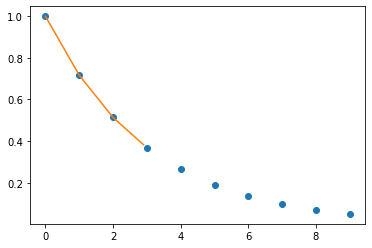

In [37]:
import matplotlib.pyplot as plt
from scipy import interpolate
x = np.arange(0, 10)
y = np.exp(-x/3.0)
print(x)
print(y)
f = interpolate.interp1d(x, y)

xnew = np.arange(0, 3, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
print(xnew)
print(ynew)
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

In [9]:
# use that path to greate a Deviation Survey Object
my_calc_obj = WellboreTrajectory(data)
my_calc_obj.deviation_survey_obj

DeviationSurvey(wellId='well_C', md=array([    0.  ,    35.  ,   774.81,   800.  ,   900.  ,  1000.  ,
        1100.  ,  1200.  ,  1300.  ,  1400.  ,  1500.  ,  1600.  ,
        1700.  ,  1800.  ,  1900.  ,  2000.  ,  2100.  ,  2200.  ,
        2300.  ,  2400.  ,  2500.  ,  2600.  ,  2700.  ,  2800.  ,
        2900.  ,  3000.  ,  3100.  ,  3200.  ,  3300.  ,  3400.  ,
        3500.  ,  3600.  ,  3700.  ,  3800.  ,  3900.  ,  4000.  ,
        4100.  ,  4200.  ,  4300.  ,  4400.  ,  4500.  ,  4600.  ,
        4700.  ,  4800.  ,  4900.  ,  5000.  ,  5100.  ,  5200.  ,
        5300.  ,  5400.  ,  5500.  ,  5600.  ,  5700.  ,  5800.  ,
        5900.  ,  6000.  ,  6100.  ,  6200.  ,  6300.  ,  6400.  ,
        6450.67,  6532.  ,  6625.  ,  6720.  ,  6813.  ,  6909.  ,
        7002.  ,  7098.  ,  7191.  ,  7286.  ,  7379.  ,  7475.  ,
        7569.  ,  7663.  ,  7758.  ,  7851.  ,  7947.  ,  8040.  ,
        8135.  ,  8229.  ,  8324.  ,  8418.  ,  8512.  ,  8606.  ,
        8700.  ,  8794.  ,

In [33]:
my_calc_obj.calculate_survey_points()
my_calc_obj.deviation_survey_obj

DeviationSurvey(wellId='well_C', md=array([    0.  ,    35.  ,   774.81,   800.  ,   900.  ,  1000.  ,
        1100.  ,  1200.  ,  1300.  ,  1400.  ,  1500.  ,  1600.  ,
        1700.  ,  1800.  ,  1900.  ,  2000.  ,  2100.  ,  2200.  ,
        2300.  ,  2400.  ,  2500.  ,  2600.  ,  2700.  ,  2800.  ,
        2900.  ,  3000.  ,  3100.  ,  3200.  ,  3300.  ,  3400.  ,
        3500.  ,  3600.  ,  3700.  ,  3800.  ,  3900.  ,  4000.  ,
        4100.  ,  4200.  ,  4300.  ,  4400.  ,  4500.  ,  4600.  ,
        4700.  ,  4800.  ,  4900.  ,  5000.  ,  5100.  ,  5200.  ,
        5300.  ,  5400.  ,  5500.  ,  5600.  ,  5700.  ,  5800.  ,
        5900.  ,  6000.  ,  6100.  ,  6200.  ,  6300.  ,  6400.  ,
        6450.67,  6532.  ,  6625.  ,  6720.  ,  6813.  ,  6909.  ,
        7002.  ,  7098.  ,  7191.  ,  7286.  ,  7379.  ,  7475.  ,
        7569.  ,  7663.  ,  7758.  ,  7851.  ,  7947.  ,  8040.  ,
        8135.  ,  8229.  ,  8324.  ,  8418.  ,  8512.  ,  8606.  ,
        8700.  ,  8794.  ,

In [ ]:
@classmethod
def from_df(cls,  df:DataFrame, wellId_name: Optional[str] = None, md_name: Optional[str] = None,
            inc_name: Optional[str] = None, azim_name: Optional[str] = None,
            surface_latitude_name: Optional[str] = None,
            surface_longitude_name: Optional[str] = None) -> 'DirectionalSurveyObj':

    # if no column names are specified use 0:5 for dir survey obj
    wellId_name = ifnone(wellId_name, df.columns[0])
    md_name = ifnone(md_name, df.columns[1])
    inc_name = ifnone(inc_name, df.columns[2])
    azim_name = ifnone(azim_name, df.columns[3])
    surface_latitude_name = ifnone(surface_latitude_name, df.columns[4])
    surface_longitude_name = ifnone(surface_longitude_name, df.columns[5])

    dataclass_obj = dict(wellId=df[wellId_name][0],
                               md=np.array(df[md_name]),
                               inc=np.array(df[inc_name]),
                               azim=np.array(df[azim_name]),
                               surface_latitude=df[surface_latitude_name][0],
                               surface_longitude=df[surface_longitude_name][0])
    return dataclass_obj

def from_csv(self, **kwargs):
    if self.extension == '.csv':
        print(self.path)
        # go through csv steps
        # Transform.from_csv: > return self.from_df
        # self.from_df > return self.from_json
        df = pd.read_csv(self.path, sep=',')
        return self.from_df(df, **kwargs)